In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

import sklearn
from sklearn.utils.class_weight import compute_class_weight
from itertools import chain

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      #tf_config = tf.ConfigProto(allow_soft_placement=False)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2 Physical GPUs, 2 Logical GPUs
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [3]:
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+'_'+time_stamp, config={} )

config = wandb.config

wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


On 2GPU Machine -Update to larger Batch size 14th March, 2022

In [4]:
# Load data
# raw_data1 = loadmat('new_echo_cnn_in_out_jstarrs2021_first_try/echo_cnn_in_out_jstars1.mat')# raw_data1 = loadmat('echo_cnn_in_out_GOOD_layers/new_echo_cnn_in_out_jstars1.mat') 'findpeaks_layers/new_echo_cnn_in_out_jstars1.mat'

load_old_data = False

if load_old_data:
    raw_data1 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars1.mat')
    raw_data2 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars2.mat')
    raw_data3 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat')
    # raw_data4 = loadmat('findpeaks_layers_rowblock20/new_echo_cnn_in_out_jstars4.mat')

    d1 = raw_data1['echo_cnn1']
    t1 = raw_data1['echo_target1']
    i1 = raw_data1['echo_idx1']
    c1 = raw_data1['coords1']

    d2 = raw_data2['echo_cnn2']
    t2 = raw_data2['echo_target2']
    i2 = raw_data2['echo_idx2']
    c2 = raw_data2['coords2']

    d3 = raw_data3['echo_cnn3']
    t3 = raw_data3['echo_target3']
    i3 = raw_data3['echo_idx3']
    c3 = raw_data3['coords3']

    # d4 = raw_data4['echo_cnn4']
    # t4 = raw_data4['echo_target4']
    # i4 = raw_data4['echo_idx4']


    orig_all_data = np.concatenate( (d1,d2,d3),axis = 0 )
    orig_all_target = np.concatenate( (t1,t2,t3),axis = 0 )
    orig_all_idx = np.concatenate( (i1,i2,i3),axis = 0 )
    coords = np.concatenate( (c1,c2,c3),axis = 0 )

    # Set all nan in the data to zero
    nan_idx = np.isnan(orig_all_data).any(axis =-1)
    orig_all_target[nan_idx] = 0
    orig_all_data[ np.isnan(orig_all_data) ]= 0

In [5]:
load_new_data = True

if load_new_data:
    # base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
    #base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531'
    base_path = '../all_block_data/PulsedTrainTest/Dec_Train_block_len_25_150322_1554'

    # Confirm path is right...
    print(f'{os.path.isdir(base_path)}')

True


In [6]:
if load_new_data:
    raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
    orig_all_data = raw_data1['echo_cnn_input']
    orig_all_target = raw_data1['echo_cnn_target']
    coords = raw_data1['coords']
    orig_all_idx = raw_data1['orig_echo_idx']

    # Set all nan in the data to zero
    nan_idx = np.isnan(orig_all_data).any(axis =-1)
    orig_all_target[nan_idx] = 0
    orig_all_data[ np.isnan(orig_all_data) ]= 0



In [7]:
# Split based on echograms into small dataset representing training and testing.

config['reduce_test_set'] = True

all_echo_idx = np.unique(orig_all_idx)

# Start split 
test_echo_idx = list(chain.from_iterable( [ list(range(20*n+1,20*n+20)) for n in range(1,int(max(all_echo_idx))//20,2) ] ) )

# list(set(test_echo_idx) & set(train_echo_idx))

if config['reduce_test_set']:
    random.Random(13).shuffle(test_echo_idx)
    test_echo_idx = test_echo_idx[:round(0.2*len(test_echo_idx))]
    # Need to get the coords of the shuffled test_echo_idx

# Create train_echo_idx     
train_echo_idx = [int(elem) for elem in all_echo_idx if elem not in test_echo_idx]

# Create new coords idx for each rowblock from all the echograms
val_cnt = [ (orig_all_idx==elem).sum() for elem in train_echo_idx]
new_coords = []
for elem in val_cnt:
    new_coords.append([*range(elem)])
new_coords = np.concatenate(new_coords).ravel()

# Get all idx of echos in train_echo_idx ( Might need to find a faster implementation)
#search_idx = np.where(orig_all_idx == train_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
search_idx = []
for echo_idx in train_echo_idx:
    search_idx.append( np.where(orig_all_idx == echo_idx)[0] )
search_idx = list(chain(*search_idx))
    
all_data = orig_all_data[search_idx]
all_target = orig_all_target[search_idx]
all_idx = orig_all_idx[search_idx]

np.testing.assert_equal(new_coords.shape[0],all_data.shape[0])

In [8]:
# Standardize all_data
standardize = False
if standardize:
    all_data  = ( all_data - all_data.mean() ) / all_data.std()

scale_data = False
if scale_data:
    all_data = 255*all_data

In [9]:
# Truncate data because data after truncate point is not good for training

truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 400

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')


In [10]:
config['row_length'] = 25 # CHANGE HERE <==
config['col_length'] = 15

# Check that the dimension of data is correct
if all_data.shape[1] == config['row_length']*config['col_length']:
    print('Dimensions match')
else:
    print(f' Row block length:{config["row_length"]} and col length:{config["col_length"]} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [11]:
# Positional Encoding

if 0 :
    time_seq = 9 #col_length #5
    # all_coords = raw_data1['coords']
    all_coord_exp = np.zeros((all_coords.shape[0],time_seq,row_length))

    for idx in range(len(all_coords)):
        a,b,c,_ = np.asarray(all_coords[idx],dtype="int")
        if (a%2) == 0: # If row index is even - this isn't implemented well because it requires iterating through individual rows
            all_coord_exp[idx] = np.sin( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )
        else:
            all_coord_exp[idx] = np.cos( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )

    if 0: #truncate_data:
        difficult_coords = all_coord_exp[stop_idx+1:]         
        all_coord_exp = all_coord_exp[:stop_idx]        


    all_coord_exp.shape    

In [12]:
max_class = config['row_length']  

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    #random.Random(13).shuffle(all_coord_exp)
    random.Random(13).shuffle(all_idx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
neigh = 4 # The number of neighbors used for each RowBlock column

x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1),order ='F' )
x_train = x_train[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_train = np.transpose(x_train,(0,2,1))
#coords_train = all_coord_exp[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1),order ='F' )
x_test = x_test[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
x_test = np.transpose(x_test,(0,2,1))
#coords_test = all_coord_exp[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1),order ='F' )
x_val = x_val[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
x_val = np.transpose(x_val,(0,2,1))
#coords_val = all_coord_exp[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
config['num_classes'] = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, config['num_classes'])
y_test_1hot  = tf.keras.utils.to_categorical(y_test, config['num_classes'])

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(1508659, 9, 25)  X_test:(282874, 9, 25)
Shape of y_train:(1508659,)  y_test:(282874,)


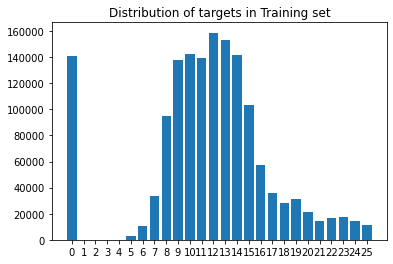

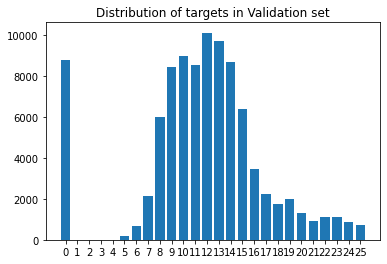

In [13]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()

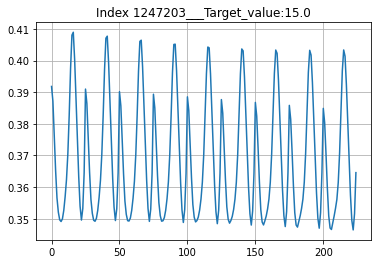

In [14]:
# Visualize some of the input
rand_idx = random.choice( range(1,x_train.shape[0]) )
_ = plt.plot(x_train[rand_idx].flatten())
_ = plt.title(f'Index {rand_idx}___Target_value:{y_train[rand_idx]}' )
_ = plt.grid(which='both')

In [15]:
if  0:   
    x_train_new = x_train + coords_train
    x_test_new = x_test + coords_test
    x_val_new = x_val + coords_val

In [16]:
# Populate the param 

# import sys,importlib
#importlib.reload(sys.modules['model_hyper_param_log'])
if 1:
    
    #base_path =   r'../../../Python_Env/final_layers_rowblock15_21/filtered_image/'
    log ={}
    log['Notebook_name'] = ipynbname.name()
    log['Uniqueness_of_each_run'] = 'Using New 2GPU machine to train 25 length data '
    log['base_dir'] = base_path
    log['Train_shape'] = x_train.shape
    log['Output_shape'] = ''
    log['num_epochs'] = ''
    log['batch_size'] = ''
    log['activation_function'] = ''
    log['optimizer'] = ''
    log['learning_rate'] = ''
    log['loss_finction'] = ''
    log['accuracy'] = []
    log['loss'] = []
    log['stop_time'] = ''
    log['Model_config'] = ''
    log['Performance_on_test_set'] = ''
    log['output_path'] = ''  # output: where the trained model is saved
    log['shuffle'] = shuffle
    log['run_completion_comment'] = '' # Comment on training and probably evaluation too
    log['extras'] = [{'standardize':standardize}]


from model_hyper_param_log import create_log_entry, update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Accuracy_per_epoch not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([62, '17_March_22_1256', 'LSTM1_Repeat_Augment_Reduce_DoubleGPU', 'Using New 2GPU machine to train 25 length data ', '../all_block_data/PulsedTrainTest/Dec_Train_block_len_25_150322_1554', (1508659, 9, 25), '', '', '', '', '', '', '', '', '', '', '', '', 1, 'DESKTOP-3S4QB77', [{'standardize': False}]])
Fields to be updated include: ['Activation_function', 'loss_function', 'Accuracy_per_epoch', '

Y:\ibikunle\Python_Project\Fall_2021\Model_and_weights\model_hyper_param_log.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Row, ignore_index=True)


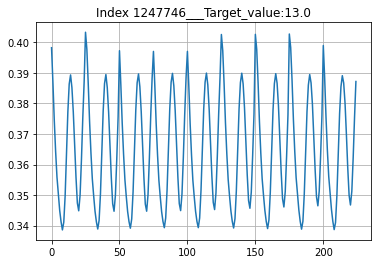

In [17]:
# Visualize some of the input
rand_idx = random.choice( range(1,x_train.shape[0]) )
_ = plt.plot(x_train[rand_idx].flatten())
_ = plt.title(f'Index {rand_idx}___Target_value:{y_train[rand_idx]}' )
_ = plt.grid(which='both')

In [18]:
data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0),        
        layers.RandomCrop(x_train.shape[1], x_train.shape[2]),
        layers.RandomFlip("vertical"),
    ],
    name="data_augmentation",
)

In [19]:
# Veiw Config 

config

{'reduce_test_set': True, 'row_length': 25, 'col_length': 15, 'num_classes': 26}

In [20]:
config['batch_size'] = batch_size= 128
AUTO = tf.data.AUTOTUNE
BUFFER = config['batch_size'] * 4

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(batch_size).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(batch_size).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_ds = test_ds.batch(batch_size).prefetch(AUTO)

In [21]:
use_class_weight = True

if use_class_weight:
    each_class,each_count = np.unique(y_train, return_counts = True)
    class_weights = len(y_train) / ( len(each_class) * each_count )
    each_class = each_class.astype('int32')
    cl_weight_dict = dict(zip(each_class,class_weights))
    
    def weighted_categorical_crossentropy(class_weight):       
        """ Returns a loss function for a specific class weight tensor
    
        Params:
          class_weight:1-D constant tensor of class weights
    
        Returns:
          A loss function where each loss is scaled based on the observed class 
        """
    
        def loss(y_obs,y_pred):
            y_obs = tf.dtypes.cast(y_obs,tf.int32)
            onehot =tf.one_hot( tf.reshape(y_obs,[-1]), depth = len(class_weight) )
            weight = tf.math.multiply(class_weight,onehot)
            weight = tf.reduce_sum(weight, axis=-1)
            losses = tf.compat.v1.losses.sparse_softmax_cross_entropy(
                            labels=y_obs, logits=y_pred, weights=weight )
            return losses
        
        return loss
    
loss = weighted_categorical_crossentropy( list( cl_weight_dict.values()) )
    

In [22]:
# Custom ResNet + LSTM model

input_shape = (x_train.shape[1:]) + (1,) #input_shape = (21,5,) #x_train.shape[2]

def ResNetBlock(x,dropout):
    x =   layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.Dropout(dropout)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.Dropout(dropout)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x

# Checkpoint path
base_path2 = r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest'

def build_model(
    input_shape,
    head_size,  
    mlp_units,
    dropout,
    mlp_dropout,
):
    inputs = tf.keras.Input(shape=input_shape) 
    
    aug_inputs = data_augmentation(inputs)    
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same")(aug_inputs)
    for _ in range(5):
        x = ResNetBlock(x,config['dropout'])        
    x = tf.reduce_sum(x,axis=-1)
    
    x = layers.LSTM(head_size, return_sequences=True)(x) #input_shape=(x.shape[1:]),recurrent_dropout= r_dropout,
    x = layers.LSTM(head_size, return_sequences=True)(x) #recurrent_dropout= r_dropout,
    x = layers.LSTM(head_size, return_sequences=True)(x) #recurrent_dropout= r_dropout,
    x = layers.LSTM(head_size)(x)

       
    #for dim in mlp_units:  x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dense(mlp_units, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    
    output1 = layers.Dense(config['num_classes'], name="output1" )(x) #activation="softmax"
    #output2 = layers.Dense(config['num_classes'], name="output2" )(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[output1],name ="RowBlockLSTM"+time_stamp)

#  Default hyper-param
config['epochs'] = 300
config['batch_size'] = 1024
config['learning_rate'] = 5e-3 
config['head_size'] = 600 #512 # 128, 256,64
config['mlp_units']= 512  # 128
config['mlp_dropout']= 0.2     #0.4
config['dropout']= 0.15          #0.25
config['r_dropout'] = 0.15
config['start_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

# Update log['extras']
log['extras'][0].update(config)


# Poly Rate scheduler
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)


# Callbacks
model_save_path = os.path.join(os.path.dirname(os.getcwd()), r'all_block_data\PulsedTrainTest')
logz= f"{model_save_path}/{ipynbname.name()}/{config['start_time']}_logs/" 
callbacks = [
    ModelCheckpoint(f"{model_save_path}/{ipynbname.name()}/RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=20, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=50, verbose=1), 
    TensorBoard(log_dir = logz,histogram_freq = 1,profile_batch = '1,70', embeddings_freq=50),
    WandbCallback()
]

top_K = 3
# opt1 = tf.keras.optimizers.RMSprop(learning_rate=1e-3,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
# opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
# opt3 = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99, nesterov=True, name="SGD")
# poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)

# Create Model for Multi-GPU

strategy = tf.distribute.MirroredStrategy( cross_device_ops=tf.distribute.HierarchicalCopyAllReduce() )
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = build_model(input_shape,head_size = config['head_size'],mlp_units=config['mlp_units'],
                    mlp_dropout= config['mlp_dropout'], dropout=config['dropout'])

    config['start_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M') # Again just before train start

    print(f"Training start time:{config['start_time']}" )

    # model.compile( optimizer = opt, loss= 'categorical_crossentropy',{"output1":loss,"output2":loss}, metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
    
    model.compile( optimizer="adam",loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy",tf.keras.metrics.SparseTopKCategoricalAccuracy(top_K, name="top-3-accuracy")] ) # tf.keras.metrics.SparseTopKCategoricalAccuracy(top_K, name="top-3-accuracy")     "sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)

y_train2 = (y_train,y_train)
y_test2 = (y_test,y_test)

history = model.fit(train_ds,
          epochs= config['epochs'], 
          batch_size= config['batch_size'], 
          #validation_split = 0.3,
          validation_data=val_ds,
         callbacks=callbacks  ) #mcp_save, callbacks=[reduce_lr_loss] class_weight = cl_weight_dict

#Load best model
model = tf.keras.models.load_model(f"{base_path2}//{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5")

config['end_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M') 
print(f"Training end_time:{config['end_time']}" )

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\wandb_run.py", line 167, in check_status
    status_response = self._interface.communicate_stop_status()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\interface\interface.py", line 114, in communicate_stop_status
    resp = self._communicate_stop_status(status)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\interface\interface_shared.py", line 387, in _communicate_stop_status
    resp = self._communicate(req, local=True)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\interface\interface_shared.py", line 222, in _communicate
    return self._communicat

 4218/11787 [=========>....................] - ETA: 12:58 - loss: 8.4891 - accuracy: 0.0941 - top-3-accuracy: 0.2914

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\wandb_run.py", line 149, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\interface\interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\interface\interface_shared.py", line 397, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\interface\interface_shared.py", line 222, in _communicate
    ret

11787/11787 [==============================] - ETA: 0s - loss: 8.5059 - accuracy: 0.0939 - top-3-accuracy: 0.2910

UnknownError: FlushFileBuffers failed for: Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest/LSTM1_Repeat_Augment_Reduce_DoubleGPU/17_March_22_1256_logs/validation/events.out.tfevents.1647541039.DESKTOP-3S4QB77.12480.1.v2 : An unexpected network error occurred.
; Unknown error
	Failed to flush 1 events to Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest/LSTM1_Repeat_Augment_Reduce_DoubleGPU/17_March_22_1256_logs/validation/events.out.tfevents.1647541039.DESKTOP-3S4QB77.12480.1.v2
	Could not flush events file. [Op:FlushSummaryWriter]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\logging\__init__.py", line 1087, in emit
    self.flush()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\logging\__init__.py", line 1067, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop.start()
  File "C:\Users\cresis\

Error in callback <function _WandbInit._pause_backend at 0x000001EAB3B1A310> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [ ]:
logz = logz.replace(os.sep,'/')

%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir={logz} --port=6022

In [ ]:
log['Uniqueness_of_each_run'] = 'Using Old data from its source'
run_completion_comment = f'First time training LSTM Test data on FilteredFiltered Old data: 66%'
if "log_idx" in globals():
    log["S_N"] = log_idx
    log['extras'][0]['run_completion_comment'] = run_completion_comment #'Accuracy_per_epoch'
    log['Accuracy_per_epoch'] = f"{history.history['accuracy'][-1]:.4f}"
    log_idx = create_log_entry('../testing_sheet2.xlsx', log)

In [ ]:
# Train further
train_further = False

if train_further:
    history = model.fit(x_train, y_train_1hot,
          epochs= 200,          
          validation_split= 0.3,
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

In [ ]:
def PlotCurves(model_history):
    plt.plot(model_history.history['accuracy'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    #plt.figure()
    plt.plot(model_history.history['val_accuracy'],label = 'validation')
   
    plt.ylabel('Accuracy');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation accuracy');
    plt.legend()
    
    plt.figure()
    
    plt.plot(model_history.history['loss'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    plt.plot(model_history.history['val_loss'],label = 'validation')
   
    plt.ylabel('Loss');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation Losses');
    plt.legend()
    return None

PlotCurves(history)

In [ ]:
# Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)

_, accuracy,top3_acc = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'..//all_block_data//PulsedTrainTest//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5') # Last percentage is 46.85, New:52.4

In [ ]:
# Convert labels to categorical orthonormal vectors
y_test_1hot = tf.keras.utils.to_categorical(y_test, num_classes)

_, accuracy,top3_acc = model.evaluate(x_test, y_test_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

_,new_col_length,new_row_length = x_train.shape 


In [ ]:
# Look at the distribution ot test and validation data

# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()

labels, counts = np.unique(y_test, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Test set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()

In [ ]:
# Dictionary for saving the result of testing all trained model to disk
exp_file_loc = r'../experiment_performance.xlsx'

df = pd.read_excel(exp_file_loc,header = 0, index_col= [0])

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\logging\__init__.py", line 1087, in emit
    self.flush()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\logging\__init__.py", line 1067, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\wandb_run.py", line 1740, in <lambda>
    atexit.register(lambda: self._atexit_cleanup())
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\wandb_run.py", line 1702, in _atexit_cleanup
    logger.info(f"got exitcode: {exit_code}")
Message: 'got exitcode: 0'
Arguments: ()
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\wandb_run.py", line 1711, in _atexit_cleanup
    self._on_finish()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\wandb\sdk\wandb_run.py", line 1801, in _on_finish
    se

In [ ]:
# Test different models in the past
#l_model_path = r"Y:\\ibikunle\\Python_Project\\Fall_2021\\all_block_data\\FindPeaks_data\Dec_Train_block_len_21_030122_0614\\NewAttention_RowBlockLSTM1\\10_January_22_1959_Acc_0.743_Top3Acc0.898_21x9.h5"
# This (commented above) was less than 20% for both test and validation
base = r'Y:\\ibikunle\\Python_Project\\Fall_2021'
paths = [ #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights\14_February_22_1859_Acc_0.644_Top3Acc0.851_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights\01_February_22_0912_Acc_0.651_Top3Acc0.838_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_Augment_Reduce\10_February_22_1201_Acc_0.638_Top3Acc0.830_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_Augment_Reduce\03_February_22_1826_Acc_0.628_Top3Acc0.846_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\NewAttention_RowBlock_Feb2022\best_model.h5",
    #r"\all_block_data\Filteredfiltered_data\LSTM1_RepeatExactly\27_January_22_2325_RowBlockLSTM_checkpoint.h5",
    #r"\all_block_data\FindPeaks_data\Dec_Train_block_len_21_030122_0614\NewAttention_RowBlockLSTM1\10_January_22_1959_Acc_0.743_Top3Acc0.898_21x9.h5",
    #r"\Model_and_weights\LSTM1_Repeat_NewData\28_January_22_1949_Acc_0.665_Top3Acc0.833_21x9.h5",
    #r"\Model_and_weights\LSTM1_Repeat_NewData-Class_weights\RowBlockLSTM_ReRun_Checkpoint01_February_22_0912.h5",
    #r"\Model_and_weights\LSTM1_Repeat_NewData-Class_weights\RowBlockLSTM_ReRun_Checkpoint14_February_22_1859.h5",
    #r"\Model_and_weights\NewAttention_RowBlockLSTM2_TrainData\CheckpointRowBlockLSTM_dropout.h5",
    #r"\Model_and_weights\NewAttention_RowBlockLSTM3_PulsedFindPeaks\RowBlockLSTM_checkpoint_26_January_22_1620.h5",
    #r"\Model_and_weights\NewAttention_RowBlockLSTM3_PulsedFindPeaks\RowBlockLSTM_checkpoint_25_January_22_0934.h5" 
    #r"\all_block_data\\NewAttention_RowBlockLSTM1\\11_January_22_16512_Acc_0.781_Top3Acc0.939_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights\14_February_22_1859_Acc_0.696_Top3Acc0.887_21x9.h5",
    #r"\all_block_data\\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights-Augment\02_February_22_1529_Acc_0.630_Top3Acc0.842_21x9.h5",
    #r"\all_block_data\\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights-Augment\02_February_22_1529_Test_Acc_0.673_Top3Acc0.885_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights-Augment\RowBlockLSTM_ReRun_Checkpoint02_February_22_1529.h5",
    r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_Augment_Reduce\25_February_22_0934_Acc_0.815_Top3Acc0.898_21x9.h5"
]
    
    
for path_idx in range(len(paths)):
    
    perf_dict = {}

    l_model_path = base + paths[path_idx]
    l_model = tf.keras.models.load_model(l_model_path)

    perf_dict['path'] = l_model_path
    perf_dict['short_path'] = os.path.basename(l_model_path)

    y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)
    _, accuracy,top3_acc = l_model.evaluate(x_val, y_val_1hot)

    print(f" Model {os.path.basename(l_model_path)} performance ")
    print(f"Val accuracy: {round(accuracy * 100, 2)}%")
    print(f"Val top 5 accuracy: {round(top3_acc * 100, 2)}%")
    print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

    perf_dict['val_accuracy'] = round(accuracy * 100, 2)
    perf_dict['val_top_K'] = round(top3_acc * 100, 2) 

    y_test_1hot = tf.keras.utils.to_categorical(y_test, num_classes)

    _, accuracy,top3_acc = l_model.evaluate(x_test, y_test_1hot)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
    print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

    perf_dict['test_accuracy'] = round(accuracy * 100, 2)
    perf_dict['test_top_K'] = round(top3_acc * 100, 2) 

    df = df.append(perf_dict, ignore_index=True)
    df.to_excel(exp_file_loc,index=False)


In [ ]:
# Test model manually on all val data

y_pred = [ np.argmax(l_model.predict(np.expand_dims(x_val[idx],axis=0))) for idx in range(len(x_val)) ]

combined_result = zip(y_val,y_pred)

val_exact_accuracy = 100 * sum([1 if y_pred[idx]==y_val[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
val_margin3_accuracy = 100 * sum([1 if abs(y_pred[idx]-y_val[idx]) < 3 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {val_margin3_accuracy: .5f} %')



In [ ]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]



In [ ]:
# Confusion Matrix and ROC/AUC

model_predictions = np.asarray(y_pred)
ground_truth = y_val.squeeze()

# Prediction per Ground-truth class
class_predictions = [ model_predictions[ground_truth==idx]  for idx in range(num_classes) ]

# Confusion matrix
confusion_mtx = np.zeros((num_classes,num_classes) )

for pred,actual in zip(y_pred,y_val): # Rows=Prediction, Columns = Actual
    confusion_mtx[pred,actual] +=1

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7,15),dpi = 100);
shw=ax.imshow(confusion_mtx)
#bar= plt.colorbar(shw)

_=plt.ylabel('Predictions')
_=plt.xlabel('Actual Class')
_=plt.title('Confusion matrix')

# ax.set_xticklabels(list(range(num_classes)))
# ax.set_yticklabels(list(range(num_classes)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#bar.set_label('ColorBar')
_ = plt.colorbar(shw, cax=cax)

In [ ]:
# Histogram of each class prediction
for idx,each_class in enumerate(class_predictions):
    _ = plt.figure()
    _ = plt.title('Class %s'%idx)
    labels, counts = np.unique(each_class, return_counts=True)
    _ = plt.bar(labels, counts, align='center')
    _ = plt.gca().set_xticks(labels)
    _ = plt.show()

In [ ]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]



In [ ]:
# Train further still( 30th Nov.,2021 X_train is returned back to default [i.e No shuffle] )
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 2, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Train further (last training 12/8/2021 was for 30 epochs - 150 epochs(w/o reshape order) previously overfitted
# Also, the train set was not reshuffled, but train further uses shuffled train data (Stopped the train further after 30 epocks- acc 14% poor. Retraining from scratch )

# New - train further: Got almost 100% acc but val acc was ~88%. Trying to push that higher

start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Restart Training start time:{start_time}')
#batch_size = 64
history2 = l_model.fit(x_train, y_train_1hot,
          epochs= 150, 
          batch_size= 128, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
PlotCurves(history2)

In [ ]:
_, accuracy,top_3_accuracy = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_3_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_top3{top_3_accuracy:.3f}_{new_row_length}x{new_col_length}.h5')

In [ ]:
# Try prediction on difficult data

if truncate_data:    

    x_difficult = raw_data1['echo_cnn_input'][stop_idx+1:]
    y_difficult = raw_data1['echo_cnn_target'][stop_idx+1:]

    x_difficult = np.reshape( x_difficult, (x_difficult.shape[0],max_class,-1) )
    x_difficult = x_difficult[:,:,mid_pt-neigh:mid_pt+neigh+1]
    # x_train = np.reshape(x_train,(x_train.shape[0],-1))
    x_difficult = np.transpose(x_difficult,(0,2,1))

    # y_difficult[y_difficult == num_classes] = 0
    # y_difficult = tf.keras.utils.to_categorical(y_difficult, num_classes)


In [ ]:
(x_difficult.shape,y_difficult.shape)

In [ ]:
# Check some predictions

difficult_start = random.randint(0,len(x_val)) #3500 #

print(f'Check start {difficult_start}')
[(int(y_difficult[idx]), np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) ) for idx in range(difficult_start,difficult_start+50) ]



In [ ]:
# Attempt loading past model (after crash) and start training again
load_model = 0
if load_model:
    model2 = tf.keras.models.load_model(r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\Old_data\Dec_Train_block_len_21_131121_2213\NewAttention_RowBlockLSTM1\22_November_21_0929_Acc_0.669_Top3Acc0.8506_21x9.h5'
                                    ,)

In [ ]:
# Train further
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 30, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)

_, accuracy,top3_acc = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5')

In [ ]:
# Test model on val data

y_diff_pred = [ np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) for idx in range(3000,3050) ] #len(x_difficult)

difficult_exact_accuracy = 100 * sum([1 if y_diff_pred[idx]==y_difficult[idx]   else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)
difficult_margin5_accuracy = 100 * sum([1 if abs(y_diff_pred[idx]-y_difficult[idx]) < 3 else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)

print(f' Exact accuracy is {difficult_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {difficult_margin5_accuracy: .5f} %')



In [ ]:
len(y_diff_pred)